In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

## Préparation générale des données

- (Déposer manuellement une des images récupérées par webscraping ou API dans le même dossier que le notebook ou travailler avec une image déjà présente.)
- Trouver la fonction d'OpenCV (cv2) permettant de charger une image, et l'utiliser pour charger l'image choisie. <br>
- A l'aide de la fonction cvtColor de cv2, convertir l'image vers l'espace COLOR_BGR2RGB.

In [9]:
def load_image(image_path: str) -> np.ndarray :
    """Load image with OpenCV and convert it to RGB."""
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

In [10]:
rose_array = load_image("rose.jpg")

- Afficher l'image à l'aide de plt.

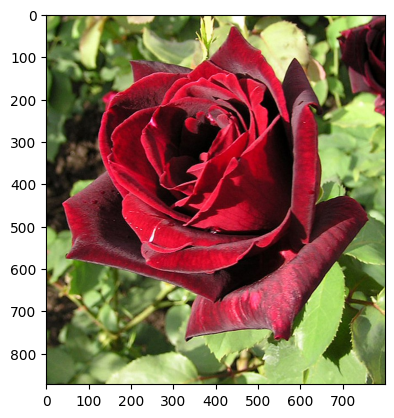

In [14]:
plt.imshow(rose_array)
plt.show()

- Afficher la taille de l'image.

In [15]:
rose_array.shape

(873, 800, 3)

- Séparer ("split") les 3 canaux de couleurs de l'image (bleu, vert, rouge).

In [19]:
rose_red, rose_green, rose_blue = cv2.split(rose_array)

- A l'aide de subplots (plt), nous allons afficher les images de chaque canal de couleur (adapter les noms de variables si nécessaire) :

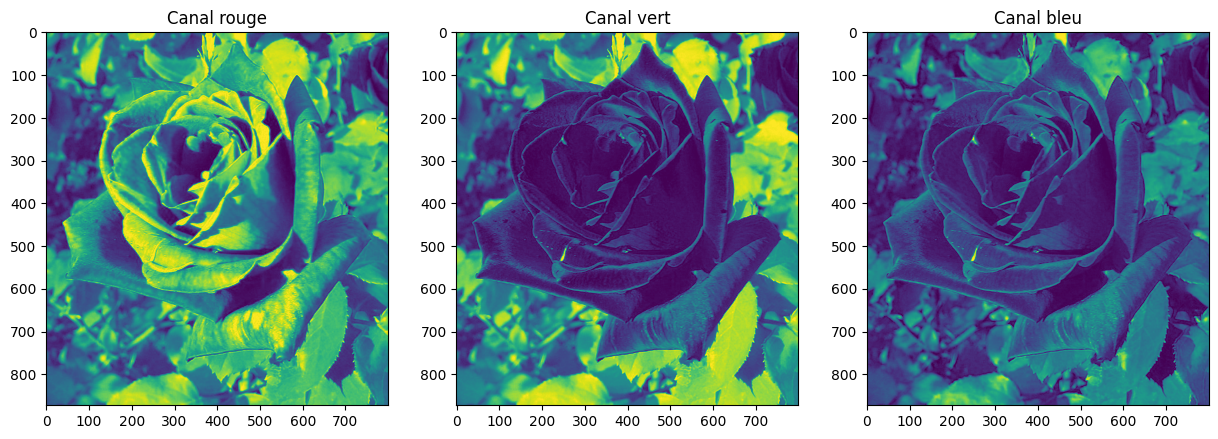

In [20]:
fig = plt.figure(figsize=(15, 7))
fig.add_subplot(131)
plt.title("Canal rouge")
plt.imshow(rose_red)
fig.add_subplot(132)
plt.title("Canal vert")
plt.imshow(rose_green)
fig.add_subplot(133)
plt.title("Canal bleu")
plt.imshow(rose_blue)
plt.show()

## Préparation spécifique des données

- Afficher les valeurs numériques contenues dans un canal de couleurs. Trouver le minimum et le maximum de ces valeurs.

In [28]:
type(rose_blue)

numpy.ndarray

- Normaliser les données.

In [29]:
scale_red = rose_red / 255
scale_green = rose_green / 255
scale_blue = rose_blue / 255

## Première ACP

- Préparer une constante comportant le nombre de composantes de l'ACP (200 pour le moment).

In [79]:
n_components = 50

- Réaliser 3 ACP distinctes pour chaque canal de couleurs, en fittant sur les données normalisées et en transformant ces mêmes données.

In [80]:
pca = PCA()
print(hasattr(pca, "components_"))
pca.fit_transform(scale_blue)
print(hasattr(pca, "components_"))

False
True


In [81]:
pca_blue = PCA(n_components=n_components)
transf_pca_blue = pca_blue.fit_transform(scale_blue)

pca_green = PCA(n_components=n_components)
transf_pca_green = pca_green.fit_transform(scale_green)

pca_red = PCA(n_components=n_components)
transf_pca_red = pca_red.fit_transform(scale_red)

- Vérifier la taille des matrices ainsi obtenues et les comparer avec les tailles initiales.

In [82]:
print(scale_red.shape)

(873, 800)


In [83]:
print(transf_pca_red.shape)

(873, 50)


- La fonction suivante permet de représenter les ratios de variance expliquée (inertie) en pourcentage, ainsi que le pourcentage cumulé. L'appeler sur les trois canaux.

In [84]:
def add_subplot(x, fitted_pca, subplot_position, channel_name) -> None:
    explained_variances = 100 * fitted_pca.explained_variance_ratio_
    fig.add_subplot(subplot_position)
    plt.title(f"Canal {channel_name}")
    plt.ylabel("Pourcentage d'inertie")
    plt.xlabel("Rang de l'axe d'inertie")
    plt.bar(x, explained_variances)
    plt.plot(x, explained_variances.cumsum(), color="red", marker="o")

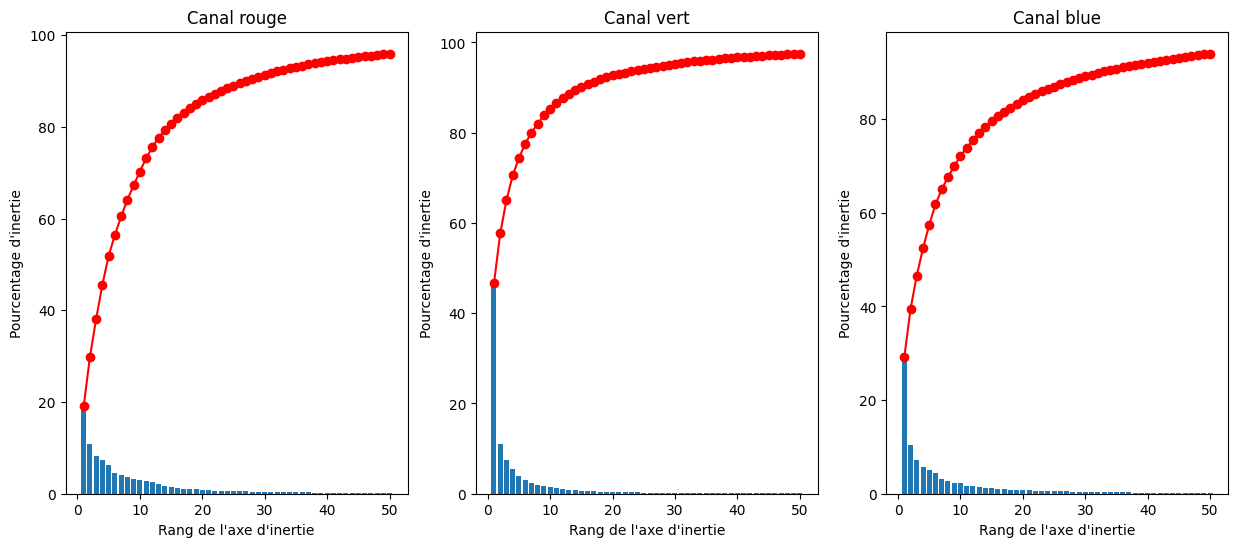

In [85]:
x = list(range(1, n_components + 1))
fig = plt.figure(figsize=(15, 6))
add_subplot(
    x=x,
    fitted_pca=pca_red,
    subplot_position=131,
    channel_name="rouge",
)
add_subplot(
    x=x,
    fitted_pca=pca_green,
    subplot_position=132,
    channel_name="vert",
)
add_subplot(
    x=x,
    fitted_pca=pca_blue,
    subplot_position=133,
    channel_name="blue",
)

- Afficher le taux de variance totale expliquée par les n_components premières composantes de l'ACP pour chaque canal de couleur.

In [86]:
print(sum(pca_blue.explained_variance_ratio_))
print(sum(pca_red.explained_variance_ratio_))
print(sum(pca_green.explained_variance_ratio_))

0.9397260224611158
0.959809191874382
0.9749727156505877


### Reconstruction de l'image réduite

- Reconstruire les tableaux numpy des différents canaux à partir des transformées inverses des ACP. Afficher les tailles des objets obtenus. 

In [87]:
reduced_red_array = pca_red.inverse_transform(transf_pca_red)
reduced_green_array = pca_green.inverse_transform(transf_pca_green)
reduced_blue_array = pca_blue.inverse_transform(transf_pca_blue)

- Reconstruire le tableau numpy de l'image globale à l'aide de la fonction merge de cv2.

In [88]:
img_reduced = cv2.merge((reduced_red_array, reduced_green_array, reduced_blue_array))

- La cellule suivante permet d'afficher côte à côte l'image initiale et l'image réduite.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


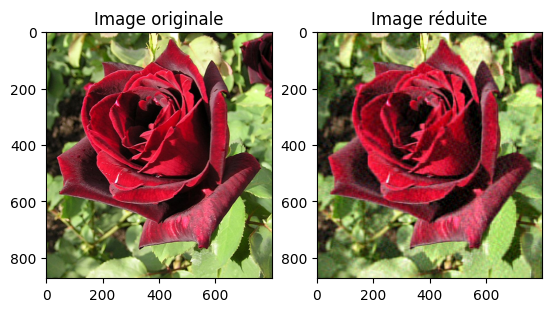

In [89]:
fig = plt.figure()
fig.add_subplot(121)
plt.title("Image originale")
plt.imshow(rose_array)
fig.add_subplot(122)
plt.title("Image réduite")
plt.imshow(img_reduced)
plt.show()

### Réglage du nombre de composantes

- A l'aide de l'éboulis des valeurs propres, proposer une valeur plus restrictive du nombre de composantes permettant malgré tout de "bien" expliquer la "plupart" de la variance. Relancer le code avec cette nouvelle valeur. Essayer éventuellement une valeur trop faible. Conclure quant à l'utilité et aux limites de l'ACP dans le contexte d'étude.